PDE Constrained Optimisation with G-ADOPT - Field Values
========================================================

In this tutorial, we invert for an (unknown) initial condition, from a given final state.

We will see how we can use the PDE constrained optimisation functionality of G-ADOPT to optimize
one of the inputs to a PDE for a specified desired outcome. We will use a time-dependent
advection-diffussion equation as our PDE and see how, for a given final state of the solution,
we can retrieve what the initial condition should be, via an adjoint approach.

To turn on the adjoint, one simply imports the gadopt.inverse module to enable all taping
functionality from pyadjoint. The tape automatically registers all operations that form part of
the forward model, which is used to automatically form the adjoint (backward) model.

In [1]:
from gadopt import *
from gadopt.inverse import *

Create synthetic twin experiment with final state for a known initial condition.
--------------------------------------------------------------------------------

We first run a simple advection-diffusion model with a known initial condition. Of that model
we only store the solution at the final timestep, which we will use in our inversion experiment
later as the target final state.

We setup the model in a form compatible with our previous examples, with a mesh, function spaces,
a prescribed velocity field, boundary conditions etc... We utilise the `EnergySolver` of G-ADOPT to
set up an energy equation under the Boussinesq Approximation, which is just a scalar
advection-diffusion equation for temperature.

In [2]:
mesh = UnitSquareMesh(40, 40)
mesh.cartesian = True

V = VectorFunctionSpace(mesh, "CG", 2)  # Function space for velocity.
Q = FunctionSpace(mesh, "CG", 1)  # Function space for the scalar (Temperature).
T = Function(Q, name="Temperature")
T0 = Function(Q, name="Initial_Temperature")  # T Initial condition which we will invert for.

# Set up prescribed velocity field -- an anti-clockwise rotation around (0.5, 0.5):
x, y = SpatialCoordinate(mesh)
u = Function(V, name="Velocity").interpolate(as_vector((-y + 0.5, x - 0.5)))

# The Rayleigh number, Ra, is not actually used here, but we set a value for the diffusivity, kappa.
approximation = BoussinesqApproximation(Ra=1, kappa=2e-2)
delta_t = 0.1  # timestep
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint)

# Setup the initial condition for Temperature: a Gaussian at $(0.75, 0.5)$.
# This will be the initial condition we will try to invert for later.

x0, y0 = 0.75, 0.5
w = 0.1
r2 = (x - x0) ** 2 + (y - y0) ** 2
T0.interpolate(exp(-r2 / w**2))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x732ac87877a0>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 4)

We can visualise the initial temperature field using Firedrake's built-in plotting functionality.

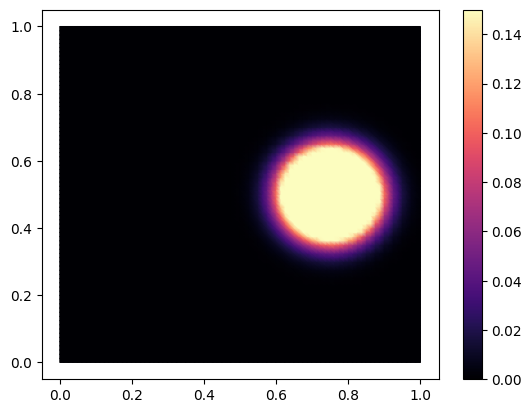

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T0, axes=axes, cmap='magma', vmax=0.15)
fig.colorbar(collection);

After setting the initial condition for T, we can next run the forward model, for a specified number of timesteps.
Pretty simple, huh?

In [4]:
num_timesteps = 10
T.project(T0)
for timestep in range(num_timesteps):
    energy_solver.solve()

We can plot the final temperature solution, which you will see has been rotated whilst simultaneously diffusing.

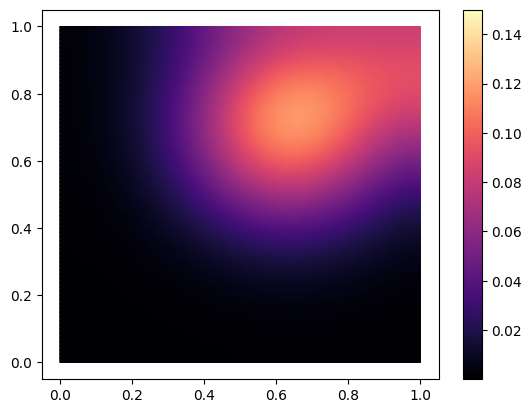

In [5]:
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='magma', vmax=0.15)
fig.colorbar(collection);

We next save this final synthetic model state in a checkpoint file for later use:

In [6]:
with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")

Advection diffusion model with unknown initial condition
--------------------------------------------------------

We now start from scratch again with an advection-diffusion model with the same configuration,
except this time we don't know the initial condition. As we want to measure for different
initial conditions, how well the final state of the model matches the one we just saved,
we first read back that target final state. We will also use the mesh from the checkpoint file
to construct the model.

In [7]:
with CheckpointFile("Final_State.h5", "r") as final_checkpoint:
    mesh = final_checkpoint.load_mesh()
    mesh.cartesian = True
    T_target = final_checkpoint.load_function(mesh, name="Temperature")

With this information stored, we now set up the model exactly as before:

In [8]:
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
T = Function(Q, name="Temperature")
T0 = Function(Q, name="Initial_Temperature")

x, y = SpatialCoordinate(mesh)
u = Function(V, name="Velocity").interpolate(as_vector((-y + 0.5, x - 0.5)))

approximation = BoussinesqApproximation(Ra=1, kappa=2e-2)
delta_t = 0.1
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint)

# Make our solver output a little less verbose, aiding interpretation of optimisation output below:
if "ksp_converged_reason" in energy_solver.solver_parameters:
    del energy_solver.solver_parameters["ksp_converged_reason"]

This time, however, we don't want to use the known initial condition. Instead we will start with
the final state from our synthetic forward model, which will then be further rotated and diffused. After
a specified number of timesteps we compute the mismatch between the predicted final state, and the
checkpointed final state from our synthetic twin. This computation, the timesteps and the mismatch calculation,
forms the forward model that we want to invert. Its adjoint will be created automatically from the tape, which
registers all operations in the model. Since the tape was automatically started at the top when we imported
`gadopt.inverse`, we must ensure we don't get mixed up with any operations that happened in our initial
synthetic twin model, so we first clear everything that has already been registered from the tape.

In [9]:
tape = get_working_tape()
tape.clear_tape()

At this stage, we are good to specify our initial guess for temperature, from T_target (i.e. the final
state of our synthetic forward run). We do this by interpolating T_target to T0. Note that in theory, we could
start from an arbitrary initial condition here, provided it is bounded between 0 and 1.

In [10]:
T0.project(T_target)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x732a6f2428d0>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 62)), 143)

We want to optimise this initial temperature state, T0, and so we specify this as the *control*:

In [11]:
m = Control(T0)

Based on our guess for the initial temperature, we run the model for a specified number of timesteps:

In [12]:
T.project(T0)
for timestep in range(num_timesteps):
    energy_solver.solve()

For good performance of optimisation algorithms, it is important to scale both the control and the
functional values to be of order 1. Note that mathematically scaling the functional should not
change the optimal solution. In the following lines, we define our scaled *functional* (J) to be the l2
misfit between predicted and true final state:

In [13]:
scaling = 1.0 / assemble(T_target**2 * dx)
J = assemble(scaling * (T - T_target) ** 2 * dx)

We can print the (scaled) mismatch:

In [14]:
print(f"Mismatch functional J={J}")

Mismatch functional J=0.4692202703792368


And plot the final temperature state (T) for comparison with the true final state (T_target)

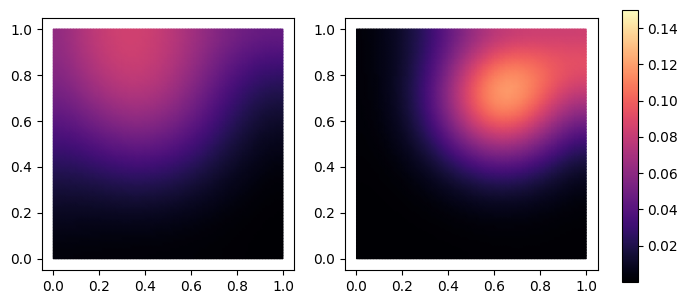

In [15]:
fig, axes = plt.subplots(1,2,figsize=[8,4],subplot_kw={'aspect':1.0})
ax1 = tripcolor(T, axes=axes[0], cmap='magma', vmax=0.15)
ax2 = tripcolor(T_target, axes=axes[1], cmap='magma', vmax=0.15)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.68])
fig.colorbar(ax2,cax=cbar_ax);

Now we have run the forward model and populated the tape with all operations required for the inverse
model, we can define the *reduced functional* which combines the functional with the control
specified above:

In [16]:
reduced_functional = ReducedFunctional(J, m)

The reduced functional allows us to rerun the forward model for different values of the control. It
can be used as a function that takes in any choice of the control, runs the forward model and
computes the functional. For instance we can rerun the model again using `T_target` as the initial
condition, i.e. re-running the exact same model we have just run:

In [17]:
print(reduced_functional(T_target))

0.46922027037923675


As expected it produces the same functional value. Now we can try to see what happens if we
use the correct initial condition, exactly matching that used in our twin experiment:

In [18]:
T0_ref = Function(Q, name="Reference_Initial_Temperature")
x0, y0 = 0.75, 0.5
w = 0.1
r2 = (x - x0) ** 2 + (y - y0) ** 2
T0_ref.interpolate(exp(-r2 / w**2))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x732a6f2428d0>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 62)), 434)

For which the functional can be printed:

In [19]:
print(reduced_functional(T0_ref))

7.55503742603594e-32


Using the "correct" initial condition, we reach the same final state as in our twin model, and thus
the functional ends up being almost exactly zero (as expected!).

In addition to re-running the model by evaluating the reduced functional, we can also calculate
its derivative. This computes the sensitivity of the model with respect to its control (the initial
condition). Here it tells us in what locations a (small) increase in the initial condition will
lead to an increase in the functional.

We want to compute the derivative at the "wrong" initial condition T_target,
so we first rerun the forward model with that value for the control

In [20]:
reduced_functional(T_target)

0.46922027037923675

We note that in unstructured mesh optimisation problems, it is important to work in the L2 Riesz
representation to ensure a grid-independent result:

In [21]:
gradJ = reduced_functional.derivative(options={"riesz_representation": "L2"})

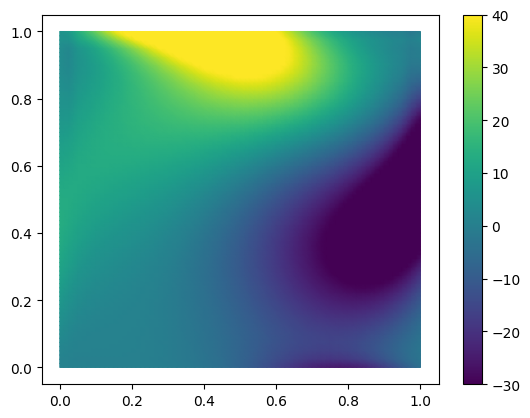

In [22]:
fig, axes = plt.subplots()
collection = tripcolor(gradJ, axes=axes, cmap='viridis', vmin=-30, vmax=40)
fig.colorbar(collection);

Invert for optimal initial condition using gradient-based optimisation algorithm
--------------------------------------------------------------------------------

We now have all ingredients required to run a gradient-based optimisation algorithm for the initial
condition:
- The ability to rerun and re-evaluate the functional for arbitrary input control values.
- The ability to compute the derivative of the functional with respect to that control.

G-ADOPT provides an interface to the [ROL optimisation library](https://trilinos.github.io/).
For this simple problem, we perform a bounded nonlinear optimisation where the temperature is
only permitted to lie in the range [0, 1]. This means that the optimisation problem should not search
for solutions beyond these values.

We therefore set lower and upper bound values for the control, which we can
provide as functions in the same function space as the control:

In [23]:
T_lb = Function(Q).assign(0.0)
T_ub = Function(Q).assign(1.0)

Our goal is to minimise the reduced functional. As such, we next define the minimisation problem,
passing on the bounds specified above. Here, we set the number of iterations to only 10,
as opposed to the default 100. Note that in some scenarios, the goal might be to
maximise (rather than minimise) the functional.

In [24]:
minimisation_problem = MinimizationProblem(reduced_functional, bounds=(T_lb, T_ub))
minimisation_parameters["Status Test"]["Iteration Limit"] = 10

In [25]:
# Define the LinMore Optimiser class:
optimiser = LinMoreOptimiser(
    minimisation_problem,
    minimisation_parameters,
)

For confirming simulation progress we record values of the reduced
functional directly in order to produce a plot of the convergence, using
a callback function:

In [26]:
functional_values = []


def record_value(value, *args):
    if functional_values:
        functional_values.append(min(value, min(functional_values)))
    else:
        functional_values.append(value)


reduced_functional.eval_cb_post = record_value

We next run the optimisation

In [27]:
optimiser.run()


Lin-More Trust-Region Method (Type B, Bound Constraints)
  iter  value          gnorm          snorm          delta          #fval     #grad     #hess     #proj     tr_flag   iterCG    flagCG    
  0     4.692203e-01   6.398024e-01   ---            1.000000e+00   1         1         0         2         ---       ---       ---       


  1     4.692203e-01   6.398024e-01   6.502412e-01   1.625603e-01   2         1         5         8         2         0         0         


  2     4.692203e-01   6.398024e-01   1.625603e-01   4.064007e-02   3         1         26        23        2         10        1         


  3     8.846225e-02   5.986398e-02   4.064007e-02   4.064007e-02   4         2         47        36        0         10        1         


  4     5.012719e-02   4.598317e-01   9.182861e-03   4.064007e-01   5         3         58        42        0         7         0         


  5     4.118939e-02   4.664927e-01   4.491746e-03   4.064007e+00   6         4         70        48        0         8         0         


  6     2.505018e-02   3.451545e-01   1.241525e-02   4.064007e+01   7         5         85        55        0         10        1         


  7     1.795687e-02   2.595304e-01   9.787225e-03   4.064007e+02   8         6         99        61        0         10        1         


  8     1.207689e-02   8.562121e-02   1.188129e-02   4.064007e+03   9         7         112       66        0         10        1         


  9     8.567071e-03   7.681285e-02   1.169701e-02   4.064007e+04   10        8         125       70        0         10        1         


  10    6.198131e-03   8.092130e-02   8.567845e-03   4.064007e+05   11        9         138       75        0         10        1         
Optimization Terminated with Status: Last Type (Dummy)


And we'll write the functional values to a file so that we can test them.

In [28]:
with open("functional_field.txt", "w") as f:
    f.write("\n".join(str(x) for x in functional_values))

At this point a total number of 10 iterations are performed. Once the optimisation
is complete, we can plot convergence, with the functional value decreasing by
roughly two orders of magnitude:

Text(0.5, 1.0, 'Convergence')

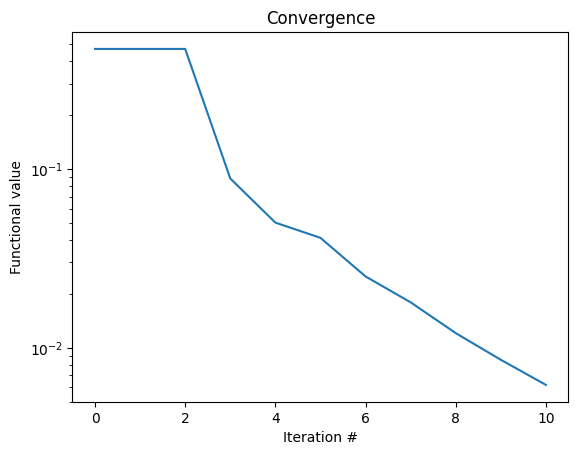

In [29]:
plt.semilogy(functional_values)
plt.xlabel("Iteration #")
plt.ylabel("Functional value")
plt.title("Convergence")

And visualise the optimised initial condition. Let's plot that and compare to the reference initial condition:

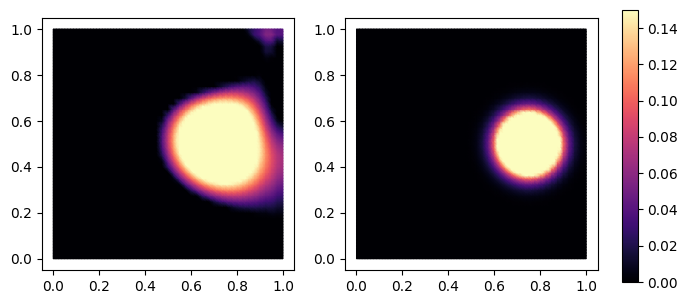

In [30]:
fig, axes = plt.subplots(1,2,figsize=[8,4],subplot_kw={'aspect':1.0})
ax1 = tripcolor(T0.block_variable.checkpoint, axes=axes[0], cmap='magma', vmax=0.15)
ax2 = tripcolor(T0_ref, axes=axes[1], cmap='magma', vmax=0.15)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.68])
fig.colorbar(ax2,cax=cbar_ax);

You can see that it has recovered the initial condition reasonably well, albeit with small
local errors. These are reduced further if the number of optimisation iterations are increased
from 10 to 20, for example, with the functional value dropping by another order of magnitude.